### PUC Minas - Trabalho de Conclusão de Curso
# **Análise de algoritmos de aprendizado profundo não supervisionado para a segmentação de fácies sísmicas**
### **Aluno:** Bryan S. Oliveira
### **Orientador:** Alexei M. C. Machado

____________________________________________________________________________

## **Método supervisionado:** Treinamento da U-Net

## Baixando os datasets e colocando na pasta "data"
F3 Block: https://zenodo.org/record/3755060/files/data.zip

In [1]:
!wget https://zenodo.org/record/3755060/files/data.zip
!openssl dgst -md5 data.zip
!unzip data.zip
!mkdir data/splits

--2023-12-17 03:37:22--  https://zenodo.org/record/3755060/files/data.zip
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3755060/files/data.zip [following]
--2023-12-17 03:37:23--  https://zenodo.org/records/3755060/files/data.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1051449986 (1003M) [application/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1003M  13.0MB/s    in 82s     

2023-12-17 03:38:46 (12.2 MB/s) - ‘data.zip’ saved [1051449986/1051449986]

MD5(data.zip)= bc5932279831a95c0b244fd765376d85
Archive:  data.zip
   creating: data/
   creating: data/train/
  inflating: data/train/train_seismic.npy  
  inflating: data/train/train_labels.npy  
   creating: data/test_once/
  inflating: data/

## Bibliotecas necessárias

In [2]:
import os
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
from functools import partial
from operator import itemgetter
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torchvision.transforms as transforms
import torchvision.transforms.functional as tf
from sklearn.model_selection import train_test_split
from scipy.ndimage import distance_transform_edt as distance

# UNet

In [3]:
# UNet's encoder-decoder architecture
# https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28


class DoubleConv(torch.nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            torch.nn.BatchNorm2d(mid_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(torch.nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(torch.nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = torch.nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(torch.nn.Module):
    def __init__(self, n_channels=1, n_classes=6, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# Attention UNet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)

            x1 = self.conv(x+x1)
        return x1

class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1


class single_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(single_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi


class U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(U_Net,self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)

        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)

        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)

        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


class R2U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,t=2):
        super(R2U_Net,self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)

        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)

        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)

        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)


        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)

        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)

        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1



class AttU_Net(nn.Module):
    def __init__(self,img_ch=1,output_ch=6):
        super(AttU_Net,self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)

        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)

        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


class R2AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,t=2):
        super(R2AttU_Net,self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)

        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)

        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)

        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)


        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)

        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)

        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

# Data Loader

Código para carregar os datasets e gerar os splits que serão usados no treino e no teste

In [4]:
"""
Data Loader
Bryan S. Oliveira
TCC - PUC/2023
"""


# Função pra criar os slices de treino (inlines e crosslines)
def split_train():
    seismic = np.load('data/train/train_labels.npy')
    irange, crange, depth = seismic.shape

    # Pega a lista de inlines
    inline_list = list(range(irange))
    inline_list = ['i_' + str(inline) for inline in inline_list]

    # Pega a lista de crosslines
    crossline_list = list(range(crange))
    crossline_list = ['x_' + str(crossline) for crossline in crossline_list]

    # Junta os dois
    train_list = inline_list + crossline_list

    # Gera uma lista de inlines e crosslines aleatórios
    train_list, test_list = train_test_split(train_list, train_size=0.99, shuffle=True)

    # Salva os slices num arquivo
    file_object = open('data/splits/train.txt', 'w')
    file_object.write('\n'.join(train_list))
    file_object.close()


# Cria os slices de teste
def split_test(test='test1', inline=True, crossline=False):
    labels = np.load(os.path.join('data', 'test_once', f'{test}_labels.npy'))
    irange, crange, depth = labels.shape

    if inline:
        inline_list = list(range(irange))
        inline_list = ['i_' + str(inline) for inline in inline_list]
    else:
        inline_list = []

    if crossline:
        crossline_list = list(range(crange))
        crossline_list = ['x_' + str(crossline) for crossline in crossline_list]
    else:
        crossline_list = []

    # create test split
    test_list = inline_list + crossline_list

    # write to files to disk:
    file_object = open(os.path.join('data', 'splits', f'{test}.txt'), 'w')
    file_object.write('\n'.join(test_list))
    file_object.close()



# Classe que implementa o Dataset de sísmicas
class SeismicDataset(Dataset):

    def __init__(self, transforms, split='train'):
        self.split = split

        # Carregando o cubo 3D correspondente ao treino/teste
        if (split == 'train'):
          self.seismic = np.load('data/train/train_seismic.npy')
          self.labels = np.load('data/train/train_labels.npy')
        else:
          self.seismic = np.load('data/test_once/' + split + '_seismic.npy')
          self.labels = np.load('data/test_once/' + split + '_labels.npy')

        self.transforms = transforms

        # Pegando os splits dos slices já separados
        splits = 'data/splits/' + split + '.txt'
        file_list = tuple(open(splits, 'r'))
        file_list = [id_.rstrip() for id_ in file_list]
        self.slices = file_list


    def __len__(self):
        return len(self.slices)


    def __getitem__(self, index):
        slice_name = self.slices[index]
        direction, number = slice_name.split(sep='_')
        slice_number = int(number)

        # Se for um inline
        if direction == 'i':
            image = self.seismic[slice_number, :, :].transpose((1,0))
            label = self.labels[slice_number, :, :].transpose((1,0))
        elif direction == 'x':
            image = self.seismic[:, slice_number, :].transpose((1,0))
            label = self.labels[:, slice_number, :].transpose((1,0))

        image = self.transform(image)
        label = self.transform(label)

        return image, label



    def transform(self, image):
        # to be in the BxCxHxW that PyTorch uses:
        if len(image.shape) == 2:
            image = np.expand_dims(image,0)

        image = torch.from_numpy(image).float()

        image = self.transforms(image)

        return image


    def get_seismic_colors(self):
        return np.asarray([ [69,117,180], [145,191,219], [224,243,248], [254,224,144], [252,141,89], [215,48,39]])


    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image
        Args:
            label_mask (numpy.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.
        Returns:
            (numpy.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_seismic_colors()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, 6):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.tight_layout()
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

# Implementação da Função de Loss

### Cross Entropy Loss

In [5]:
"""
Função de perda "Cross Entropy Loss"
Bryan S. Oliveira
TCC - PUC/2023
"""

class CrossEntropyLoss:
    def __init__(self, ignore_index=255, label_smoothing=0.0, reduction='none', weight=None):
        self.ignore_index = ignore_index
        self.label_smoothing = label_smoothing
        self.reduction = reduction
        self.weight = weight


    def __call__(self, slices, targets):
        if len(targets.shape) > 3:
            targets = torch.squeeze(targets.long(), dim=1)
        return torch.nn.functional.cross_entropy(slices, targets, ignore_index=self.ignore_index, label_smoothing=self.label_smoothing, reduction=self.reduction, weight=self.weight)


# Treinamento

In [6]:
"""
Processo de treinamento da U-Net
Bryan S. Oliveira
TCC - PUC/2023
"""

def train():

  # Processador ou GPU
  device = torch.device(
      "cuda" if torch.cuda.is_available()
      else "cpu"
  )

  print('🔹 Device configurado -> ' + str(device))

  # Constantes de treinamento
  NUM_EPOCHS = 20
  LEARNING_RATE = 0.001
  BATCH_SIZE = 16

  # Pré-processamento (transformações) das imagens
  transform = transforms.Compose([
      transforms.Resize((256,256))
  ])

  # Gera os splits de treino
  split_train()

  print('🔹 Gerou splits de treino')

  # Cria o dataset de treino
  train_dataset = SeismicDataset(transforms=transform, split='train')
  train_loader = DataLoader(
      train_dataset,
      batch_size=BATCH_SIZE,
      shuffle=True
  )

  print('🔹 Gerou o dataset completo de treino \n')

  # Criando o modelo
  model = UNet().to(device)
  criterion = CrossEntropyLoss(reduction='mean')
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  print('🔹 Começando o treinamento...\n')
  train_loss = []


  # Processo de treinamento
  for epoch in range(NUM_EPOCHS):
      model.train()
      running_loss = 0.0

      for data in train_loader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          outputs = model(images)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

      loss = running_loss / len(train_loader)
      train_loss.append(loss)

      print('Epoch {} of {}, Train Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, loss))

  print('\n✅ Treinamento Finalizado!\n')
  plt.plot(train_loss)

  return model

🔹 Device configurado -> cuda
🔹 Gerou splits de treino
🔹 Gerou o dataset completo de treino 

🔹 Começando o treinamento...



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 of 20, Train Loss: 0.4111
Epoch 2 of 20, Train Loss: 0.0981
Epoch 3 of 20, Train Loss: 0.0684
Epoch 4 of 20, Train Loss: 0.0588
Epoch 5 of 20, Train Loss: 0.0473
Epoch 6 of 20, Train Loss: 0.0623
Epoch 7 of 20, Train Loss: 0.0665
Epoch 8 of 20, Train Loss: 0.0514
Epoch 9 of 20, Train Loss: 0.0472
Epoch 10 of 20, Train Loss: 0.0446
Epoch 11 of 20, Train Loss: 0.0422
Epoch 12 of 20, Train Loss: 0.0635
Epoch 13 of 20, Train Loss: 0.0425
Epoch 14 of 20, Train Loss: 0.0403
Epoch 15 of 20, Train Loss: 0.0398
Epoch 16 of 20, Train Loss: 0.0368
Epoch 17 of 20, Train Loss: 0.0365
Epoch 18 of 20, Train Loss: 0.0452
Epoch 19 of 20, Train Loss: 0.0457
Epoch 20 of 20, Train Loss: 0.0651

✅ Treinamento Finalizado!



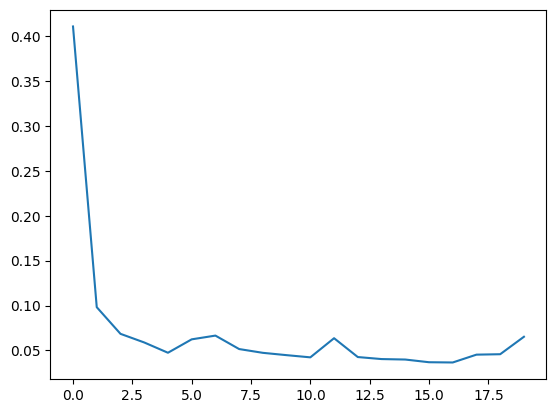

In [7]:
model = train()

# Métricas

In [8]:
def test_image_reconstruction(image, predict):
    figure = plt.figure()
    ax1 = figure.add_subplot(121)
    ax2 = figure.add_subplot(122)
    sim1 = ax1.imshow(image.cpu().detach().numpy().transpose((1,2,0)), cmap = 'Greys')
    sim2 = ax2.imshow(predict.cpu().detach().numpy().transpose((1,2,0)), cmap = 'Greys')
    plt.show()

In [9]:
class RunningScore(object):
    def __init__(self, n_classes, threshold=None):
        self.bfs_threshold = threshold
        self.bfs_matrix = [0.] if self.bfs_threshold is None else list()
        self.confusion_matrix = torch.zeros((n_classes, n_classes))
        self.epoch_counter = 0
        self.n_classes = n_classes

    def __compute_matrix(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = torch.bincount(n_class * label_true[mask].to(int) + label_pred[mask], minlength=n_class**2).reshape(n_class, n_class)
        return hist.cpu()

    def __find_class_contours(self, matrix, label):
        lbl_matrix = (matrix == label).int()
        gt_tb  = lbl_matrix[1:,:] - lbl_matrix[:-1,:]
        gt_lr  = lbl_matrix[:,1:] - lbl_matrix[:,:-1]
        gt_tb  = torch.nn.functional.pad(input=gt_tb, pad=[0,0,0,1], mode='constant', value=0) != 0
        gt_lr  = torch.nn.functional.pad(input=gt_lr, pad=[0,1,0,0], mode='constant', value=0) != 0
        gt_idx = torch.nonzero((gt_lr + gt_tb) == 1, as_tuple=False)
        return gt_idx

    def __compute_boundary(self, label_trues, label_preds):
        device_idx = label_trues.get_device()
        device = device_idx if device_idx >= 0 else 'cpu'
        bf_scores = torch.zeros(self.n_classes, device=device)
        for label in range(self.n_classes):
            # Removing len=1 axes from matrices
            preds, trues = label_preds.squeeze(), label_trues.squeeze()
            # Find matrix indices storing boundaries
            contour_pr = self.__find_class_contours(preds, label)
            contour_tr = self.__find_class_contours(trues, label)
            # Compute BF1 Score
            if len(contour_pr) and len(contour_tr):
                # Compute Precision and Recall
                precis, pre_num, pre_den = self.__precision_recall(contour_tr, contour_pr, self.bfs_threshold)
                recall, rec_num, rec_den = self.__precision_recall(contour_pr, contour_tr, self.bfs_threshold)
                bf_scores[label] += (2 * recall * precis / (recall + precis)) if (recall + precis) > 0 else 0.
            else: bf_scores[label] += 0
        return bf_scores

    def __precision_recall(self, vector_a, vector_b, threshold=2):
        """
        For precision, vector_a==GT & vector_b==Prediction
        For recall, vector_a==Prediction & vector_b==GT
        """
        # Constrain long arrays when their size differ significantly
        upper_bound = max([len(vector_a), len(vector_b)])
        lower_bound = min([len(vector_a), len(vector_b)])
        bound = upper_bound if (upper_bound/lower_bound <= 2.) else lower_bound
        # Shrinking vectors
        vector_a = vector_a[:bound].float()
        vector_b = vector_b[:bound].float()
        # Efficient and ellegant implementation of Euclidean Distance
        distance  = torch.cdist(vector_a, vector_b, p=2)
        top_count = torch.any(distance < threshold, dim=0).sum()
        # Not very ellegant implementation of Euclidean Distance (time consuming)
        # hits = list()
        # for point_b in vector_b:
        #     distance = torch.square(vector_a[:,0] - point_b[0]) + torch.square(vector_a[:,1] - point_b[1])
        #     hits.append(torch.any(distance < threshold**2))
        # top_count = torch.sum(torch.as_tensor(hits))
        try:
            precision_recall = top_count / len(vector_b)
        except ZeroDivisionError:
            precision_recall = 0
        return precision_recall, top_count, len(vector_b)

    def update(self, slices, targets):
        label_preds, label_trues = slices.detach().max(dim=1)[1], targets.detach() #.cpu().numpy()
        for lp, lt in zip(label_preds, label_trues):
            self.confusion_matrix += self.__compute_matrix(lt.flatten(), lp.flatten(), self.n_classes)
            if self.bfs_threshold is not None:
                self.bfs_matrix.append(self.__compute_boundary(lt, lp))

    def get_scores(self, epoch=None):
        """
        Returns accuracy score evaluation result.
            - overall accuracy
            - mean accuracy
            - mean IU
            - fwavacc
        """
        self.epoch_counter = (self.epoch_counter + 1) if epoch is None else epoch
        bfs = torch.mean(torch.stack(self.bfs_matrix))
        hist = self.confusion_matrix
        acc = torch.diag(hist).sum() / hist.sum()
        acc_cls = torch.diag(hist) / hist.sum(dim=1)
        mean_acc_cls = torch.nanmean(acc_cls)
        iu = torch.diag(hist) / (hist.sum(dim=1) + hist.sum(dim=0) - torch.diag(hist))
        mean_iu = torch.nanmean(iu)
        freq = hist.sum(dim=1) / hist.sum() # fraction of the pixels that come from each class
        fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
        cls_iu = dict(zip(range(self.n_classes), iu))
        return {'Epoch': self.epoch_counter,
                'Decision': mean_iu.item() if self.bfs_threshold is None else bfs.item(),
                'BF1 Score': bfs.item(),
                'Pixel Acc': acc.item(),
                'Class Accuracy': acc_cls.tolist(),
                'Mean Class Acc': mean_acc_cls.item(),
                'Freq Weighted IoU': fwavacc.item(),
                'Mean IoU': mean_iu.item(),
                'Confusion Matrix': self.confusion_matrix.tolist()}

    def reset(self):
        self.bfs_matrix = [0] if self.bfs_threshold is None else list()
        self.confusion_matrix = torch.zeros((self.n_classes, self.n_classes))

# Teste

In [12]:
"""
Processo de testes da U-Net
Bryan S. Oliveira
TCC - PUC/2023
"""

def test(model, split='test1'):

  BATCH_SIZE = 16

  # Processador ou GPU
  device = torch.device(
      "cuda" if torch.cuda.is_available()
      else "cpu"
  )

  # Pré-processamento (transformações) das imagens
  transform = transforms.Compose([
      transforms.Resize((256,256))
  ])

  # Gera os splits de teste
  split_test(test=split)

  print('🔹 Gerou splits de teste')

  # Cria o dataset de teste
  test_dataset = SeismicDataset(transforms=transform, split=split)
  test_loader = DataLoader(
      test_dataset,
      batch_size=BATCH_SIZE,
      shuffle=True
  )

  running_metrics = RunningScore(6, threshold=2)

  print('🔹 Gerou o dataset completo de teste \n')

  print('🔹 Começando os testes \n')
  for data in test_loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)

      with torch.no_grad():
        outputs = model(images)

      # Usar essa função para mostrar o resultado da segmentação
      # test_image_reconstruction(labels[0], outputs[0])

      running_metrics.update(slices=outputs, targets=labels)

      labels_original = labels.cpu().numpy()[0]
      labels_decoded = test_dataset.decode_segmap(np.squeeze(labels_original), plot=True)

      out = torch.nn.functional.softmax(outputs, dim=1)
      prediction = out.max(1)[1].cpu().numpy()[0]
      decoded = test_dataset.decode_segmap(np.squeeze(prediction), plot=True)

  score = running_metrics.get_scores()

  print('--------------- FINAL RESULTS -----------------')
  print(f'BF1 Score: {score["BF1 Score"]:.3f}')
  print(f'Pixel Acc: {score["Pixel Acc"]:.3f}')
  for c in range(6):
      print(f'     {c+1}_accuracy {score["Class Accuracy"][c]:.3f}')
  print(f'Mean Class Acc: {score["Mean Class Acc"]:.3f}')
  print(f'Freq Weighted IoU: {score["Freq Weighted IoU"]:.3f}')
  print(f'Mean IoU: {score["Mean IoU"]:0.3f}')
  print('-----------------------------------------------\n')

🔹 Gerou splits de teste
🔹 Gerou o dataset completo de teste 

🔹 Começando os testes 



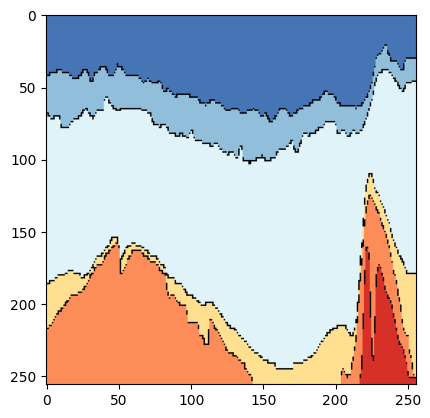

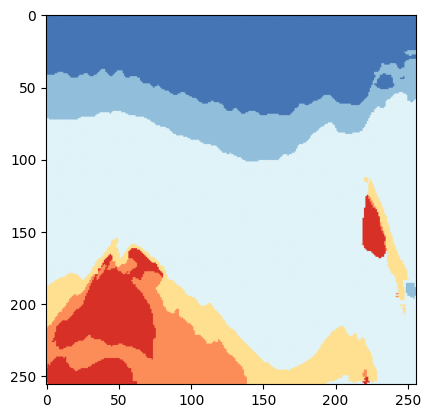

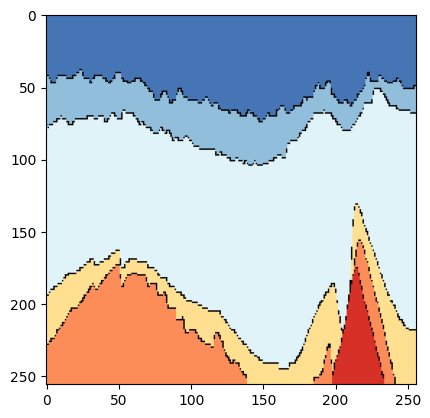

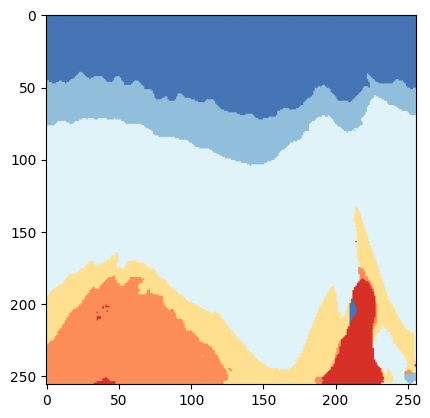

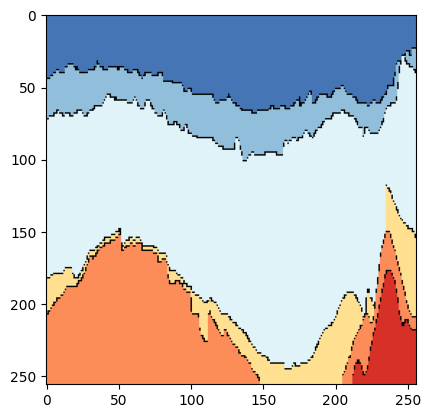

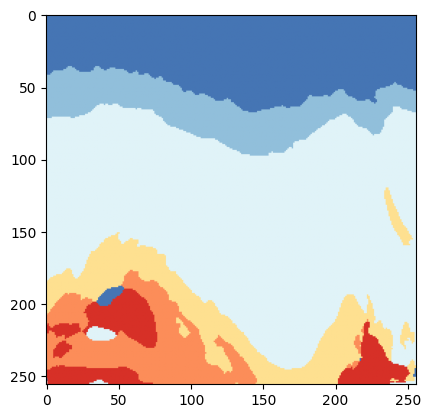

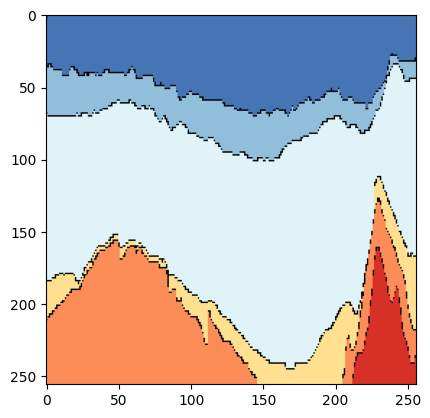

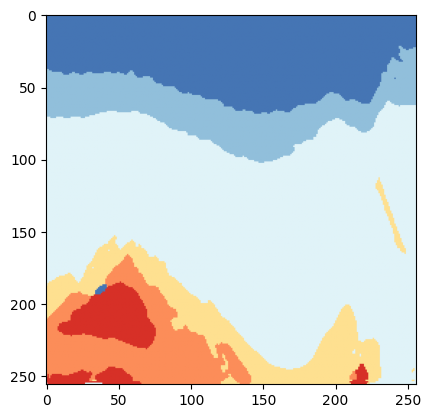

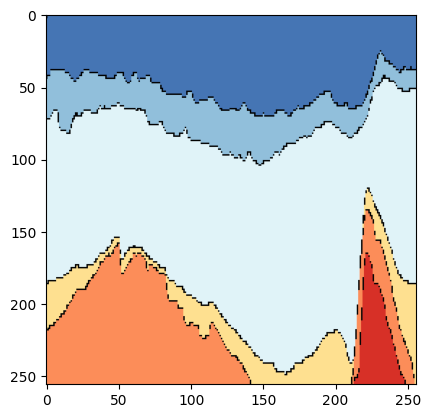

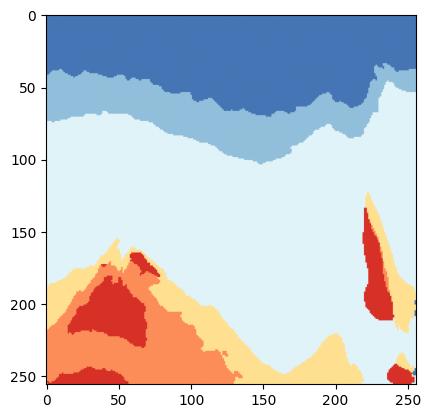

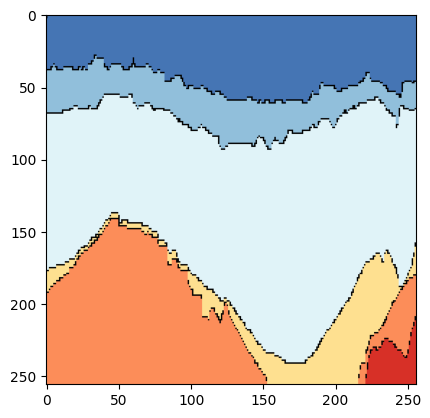

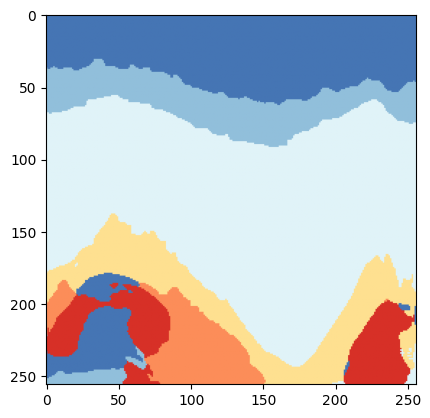

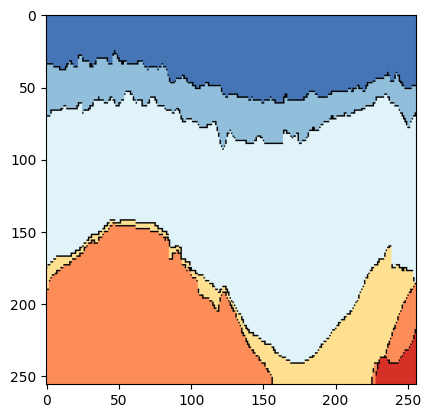

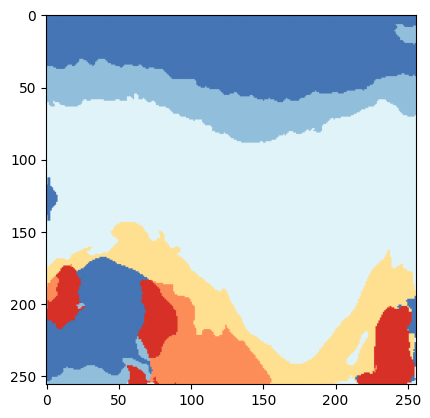

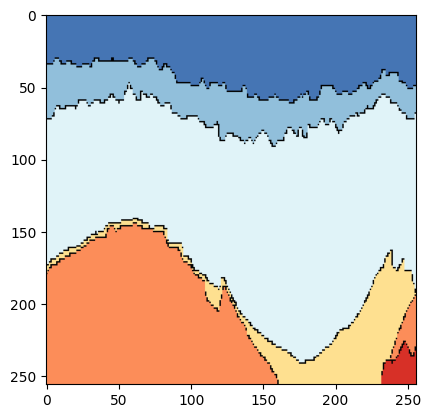

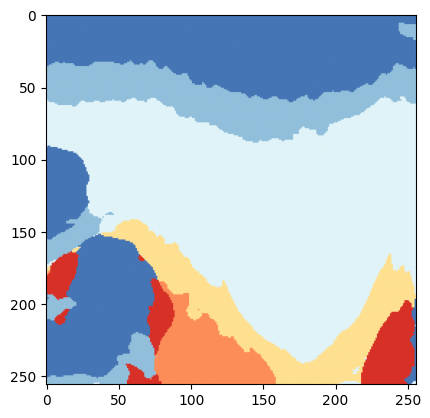

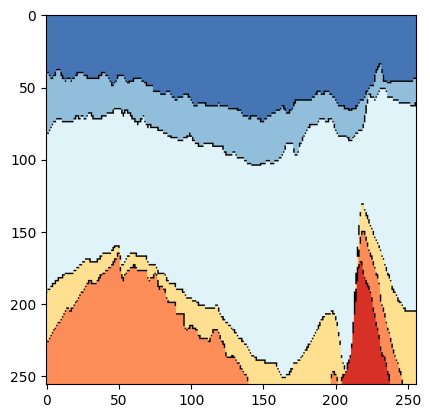

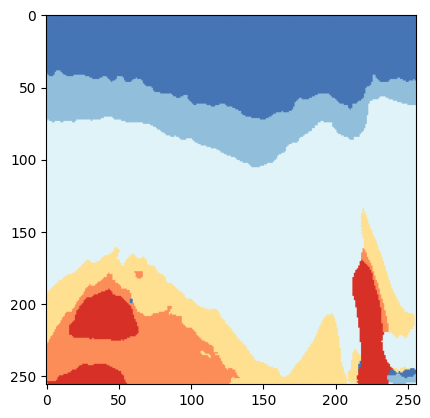

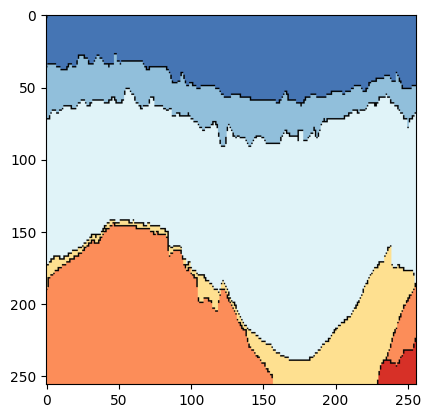

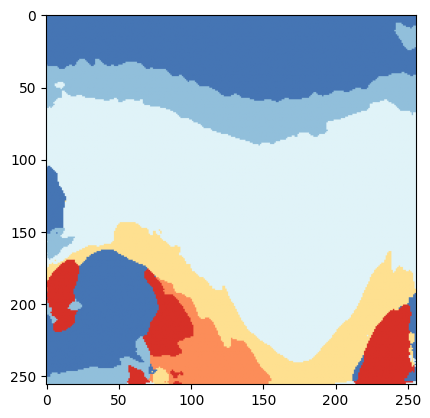

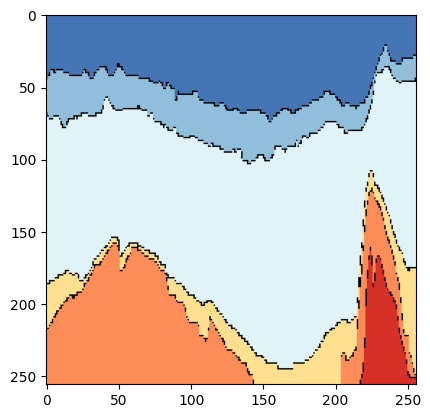

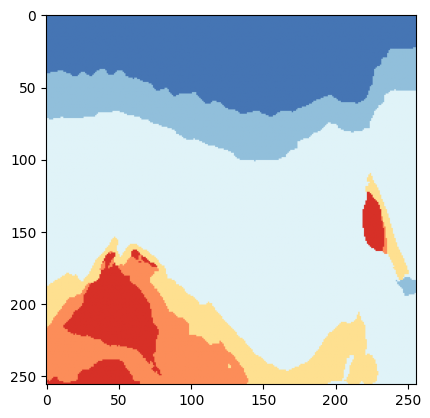

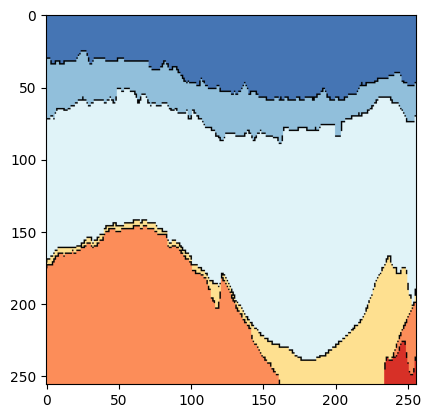

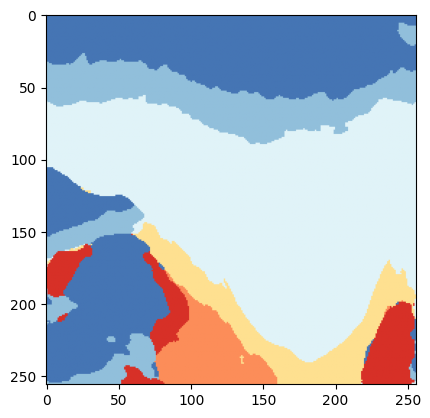

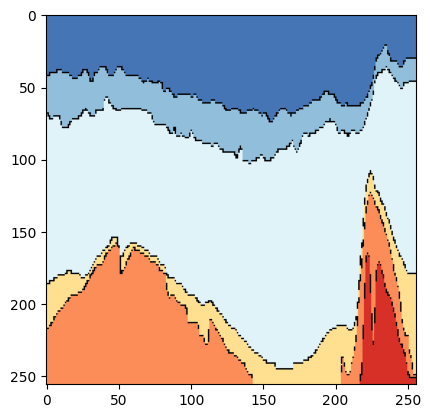

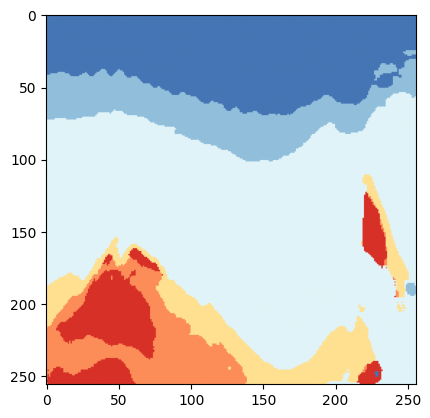

--------------- FINAL RESULTS -----------------
BF1 Score: 0.454
Pixel Acc: 0.836
     1_accuracy 0.977
     2_accuracy 0.933
     3_accuracy 0.952
     4_accuracy 0.815
     5_accuracy 0.358
     6_accuracy 0.458
Mean Class Acc: 0.749
Freq Weighted IoU: 0.740
Mean IoU: 0.587
-----------------------------------------------



In [13]:
test(model, split='test1')